# Are we undercounting Global Methane Emissions?

## Intro

According to the United Nations Environment Program "methane is the primary contributor to the formation of ground-level ozone." Over 20 years, "it is 80 times more potent at warming than carbon dioxide." [(UNEP)](https://www.unep.org/news-and-stories/story/methane-emissions-are-driving-climate-change-heres-how-reduce-them).  In fact, one kilogram of CH4 produced is equivalent to 25 kilograms of CO2.[(Econometra)[https://ecometrica.com/assets/GHGs-CO2-CO2e-and-Carbon-What-Do-These-Mean-v2.1.pdf].  

The agricultural industry is the primary producer of methane emissions globally.  While the cattle industry is a well known culprit, paddy rice cultivation – in which flooded fields are ideal breeding grounds for methan-emitting bacteria - accounts for another 8 per cent of human linked emissions .[source](https://www.unep.org/news-and-stories/story/methane-emissions-are-driving-climate-change-heres-how-reduce-them).  This equates to an average insert equivalency here to rice cultivation.  


## Measuring Paddy Rice CH4 Emissions

FAOStat (insert source here ) is the leading provider of methane emissions estimates.  They estimate their values by multiplying reported hectares of cultivated land by a conversion factor of (insert here).  The accuracy of their data is questionable as they rely upon government sources which may have incentives to forge reports in order to recieve foreign direct investment or aid from NGO's.

TRACE on the other hand estimates emissions levels by calculating the area of cultivated paddies with Satalite imaging at 500 meters and multiplying that number by a different conversion factor.   While this method may undercount small fields and cultivation at higher altitudes, the metric does not rely upon possibly manipulated sources. It is important to not that they use a conversion factor that differs from FAOSTAT.

## University of Malaysia Paper

The University of Malaysia found a 16 percent difference when comparing TRACE's 2020 data to FAOSTAT's 2020 data.  I could not replicate these results exactly.  I found a 6 percent difference when attempting to recreate the paper. University of Malaysia rounds to higher value than the floating point results in my data set.  Please review that work here.

The findings of my intial analsys led me to discover whether Governments are truly undercounting global methane emissions.  

## The Data

### Python Libraries Import

The libraries below will be used to analyze the data in the post. The resulting error can be ignored for the time being. The unfortanate reality of python programming is that dependencies often break when packages are updated.  

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import distance
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Data Import

We will be reviewing the data provided by FAOSTAT and TRACE.  The dataframe imported was prepared for this post.  You may review the documentation here.  [insert link here]

In [180]:
filepath = "/Users/jnapolitano/Projects/wattime-takehome/data/MERGE_DATA_GEO.geojson"

merge_geo_df = gpd.read_file(filepath)

## Convert to 3857 for easier plotting and spatial math if necessary
merge_geo_df = merge_geo_df.to_crs(epsg=3857)


### CH4 Data

There is too much noise in the data to make sense of it as is.  Let's slice the totals to getter a better look.

In [182]:
ch4_data = merge_geo_df[['country_name_FAOSTAT', 'continent','CH4_abs_percent_diff_totals', 'CH4_relative_percent_diff_totals', 'CH4_diff_totals','2015', 'tCH4_2015','2016', 'tCH4_2016','2017', 'tCH4_2017','2017', 'tCH4_2017','2018', 'tCH4_2018', '2019', 'tCH4_2019']].copy()
ch4_data

,country_name_FAOSTAT,continent,CH4_abs_percent_diff_totals,CH4_relative_percent_diff_totals,CH4_diff_totals,2015,tCH4_2015,2016,tCH4_2016,2017,tCH4_2017,2017,tCH4_2017,2018,tCH4_2018,2019,tCH4_2019
0,Bangladesh,Asia,63.425917,-92.881337,-5.265110e+06,1131293.4,2.344420e+06,1.093480e+06,2.278158e+06,1.154531e+06,2.098958e+06,1.154531e+06,2.098958e+06,1.144591e+06,2.141231e+06,1.144745e+06,2.070985e+06
1,Brazil,South America,93.222402,-174.610414,-1.096923e+06,138910.3,3.410233e+05,1.262782e+05,3.104189e+05,1.303229e+05,3.725173e+05,1.303229e+05,3.725173e+05,1.216152e+05,3.717030e+05,1.110848e+05,3.294713e+05
2,China,Asia,9.421813,-9.887609,-2.642293e+06,5406593.9,6.133647e+06,5.399920e+06,5.859531e+06,5.400129e+06,6.355071e+06,5.400129e+06,6.355071e+06,5.302173e+06,5.413962e+06,5.214455e+06,5.603352e+06
3,Spain,Europe,124.705066,76.811284,2.069382e+05,55082.2,1.141464e+04,5.507310e+04,1.334803e+04,5.423240e+04,1.217299e+04,5.423240e+04,1.217299e+04,5.292500e+04,1.405410e+04,5.209850e+04,1.148324e+04
4,Indonesia,Asia,70.153790,51.936188,6.172158e+06,2407953.5,1.283649e+06,2.387656e+06,1.023129e+06,2.425291e+06,9.615327e+05,2.425291e+06,9.615327e+05,2.405614e+06,1.176982e+06,2.257604e+06,1.266668e+06
5,India,Asia,32.086209,-38.217479,-8.806357e+06,4580248.4,6.219887e+06,4.559136e+06,5.309413e+06,4.620791e+06,6.228451e+06,4.620791e+06,6.228451e+06,4.661155e+06,6.589798e+06,4.621417e+06,7.501556e+06
6,Iran (Islamic Republic of),Asia,13.260902,12.436318,6.526191e+04,116486.7,8.774407e+04,1.310085e+05,9.180121e+04,8.723360e+04,9.620217e+04,8.723360e+04,9.620217e+04,9.393660e+04,8.875744e+04,9.610340e+04,9.500199e+04
7,Italy,Europe,80.187551,57.238482,3.267972e+05,114574.8,4.995968e+04,1.180030e+05,4.937785e+04,1.180030e+05,5.443679e+04,1.180030e+05,5.443679e+04,1.094638e+05,4.469902e+04,1.108951e+05,4.566914e+04
8,Japan,Asia,36.874729,31.134372,5.053990e+05,330353.1,2.305465e+05,3.264030e+05,2.284133e+05,3.237003e+05,2.708935e+05,3.237003e+05,2.708935e+05,3.222450e+05,1.548252e+05,3.205818e+05,2.332056e+05
9,Cambodia,Asia,14.304565,-15.406481,-3.570168e+05,436826.0,4.954698e+05,4.590031e+05,5.731698e+05,4.737453e+05,4.517045e+05,4.737453e+05,4.517045e+05,4.793627e+05,5.592610e+05,4.683789e+05,5.947277e+05


### Impressions

FAOSTAT undereports by about 3 percent in comparison to TRACE.  It is interesting to note that countries with relatively effficient beauracracies over report in comparison to TRACE. Review the plot below for greater detail.
 

### CH4 Relative Percent Differences Plot

<AxesSubplot:title={'center':'Relative Percent Global CH4 Emissions 2015 - 2019'}, ylabel='Country Name'>

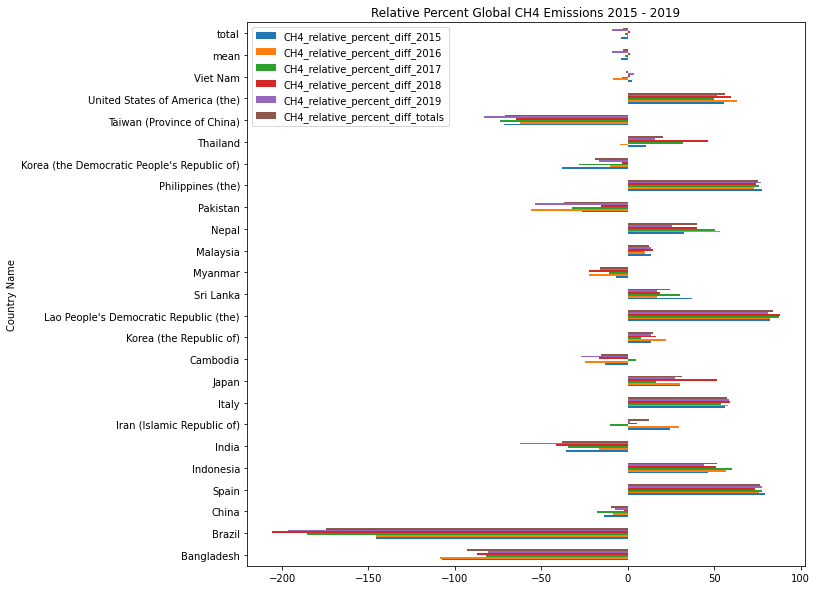

In [189]:
merge_geo_df.plot(kind = "barh", x = 'country_name_FAOSTAT', y = ['CH4_relative_percent_diff_2015', 'CH4_relative_percent_diff_2016','CH4_relative_percent_diff_2017', 'CH4_relative_percent_diff_2018', 'CH4_relative_percent_diff_2019','CH4_relative_percent_diff_totals'], xlabel = "Country Name", ylabel = "Tonnes CH4", title = "Relative Percent Global CH4 Emissions 2015 - 2019", figsize = (10,10))

### Percent Difference Map

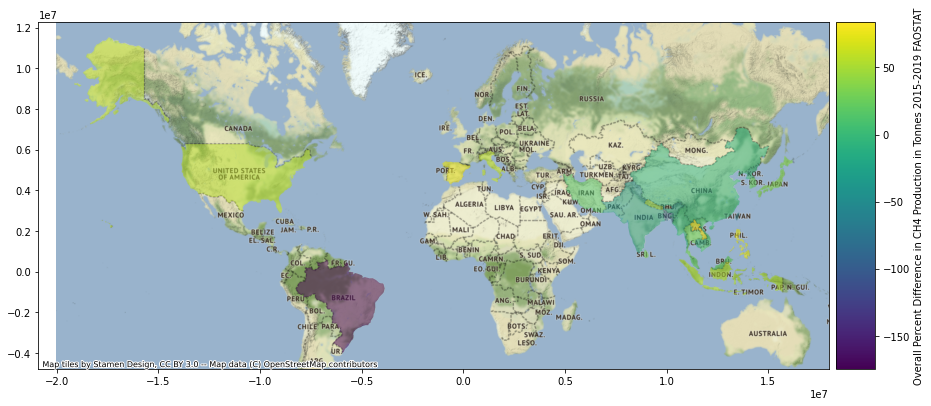

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge_map = merge_geo_df.plot(column='CH4_relative_percent_diff_totals', ax=ax, legend=True, cax=cax, alpha = .5,legend_kwds={'label': "Overall Percent Difference in CH4 Production in Tonnes 2015-2019 FAOSTAT",
                        'orientation': "vertical"})
cx.add_basemap(merge_map, zoom=3)

### Discusion of Aggregated Data Points

FAOSTAT on average undercounts by about 3 percent in comparison to the TRACE DATA.   This may not prove to be statistically significant.  That test must be completed, it is consistently demonstrated in the data across nearly every distribution. 

## Which Report should We Rely Upon?

The simple is answer is both.  The TRACE and the FAOSTAT methods can result in estimation errors.  The Trace methedology may undercount paddies in cultivation due to limited sensor accuracy.  The FAOSTAT methods may be intentionaly manipulated by governments or simply be erroneous due to ineficcient beauracricies.

Considering the fact that the TRACE methods typically estimate greater emissions than the FAOSTAT method, despite sensor limitations I expect their data to more accurately estimate global methane emissions.  

### Tonnes Ch4 2015 - 2019 TRACE

In [201]:
TRACE_CH4_df = merge_geo_df[['country_name_TRACE','tCH4_2015', 'tCH4_2016', 'tCH4_2017', 'tCH4_2018', 'tCH4_2019']].copy()
TRACE_CH4_df['Means'] = TRACE_CH4_df.select_dtypes(np.number).mean(axis=1)
TRACE_CH4_df

,country_name_TRACE,tCH4_2015,tCH4_2016,tCH4_2017,tCH4_2018,tCH4_2019,Means
0,Bangladesh,2.344420e+06,2.278158e+06,2.098958e+06,2.141231e+06,2.070985e+06,2.186750e+06
1,Brazil,3.410233e+05,3.104189e+05,3.725173e+05,3.717030e+05,3.294713e+05,3.450268e+05
2,China,6.133647e+06,5.859531e+06,6.355071e+06,5.413962e+06,5.603352e+06,5.873113e+06
3,Spain,1.141464e+04,1.334803e+04,1.217299e+04,1.405410e+04,1.148324e+04,1.249460e+04
4,Indonesia,1.283649e+06,1.023129e+06,9.615327e+05,1.176982e+06,1.266668e+06,1.142392e+06
5,India,6.219887e+06,5.309413e+06,6.228451e+06,6.589798e+06,7.501556e+06,6.369821e+06
6,Iran (Islamic Republic of),8.774407e+04,9.180121e+04,9.620217e+04,8.875744e+04,9.500199e+04,9.190138e+04
7,Italy,4.995968e+04,4.937785e+04,5.443679e+04,4.469902e+04,4.566914e+04,4.882850e+04
8,Japan,2.305465e+05,2.284133e+05,2.708935e+05,1.548252e+05,2.332056e+05,2.235768e+05
9,Cambodia,4.954698e+05,5.731698e+05,4.517045e+05,5.592610e+05,5.947277e+05,5.348666e+05


Note a mean total of 22,465,500 Tonnes Produced between 2015 - 2019.

<AxesSubplot:title={'center':'Tonnes Global CH4 Emissions 2015 - 2019'}, ylabel='Country Name'>

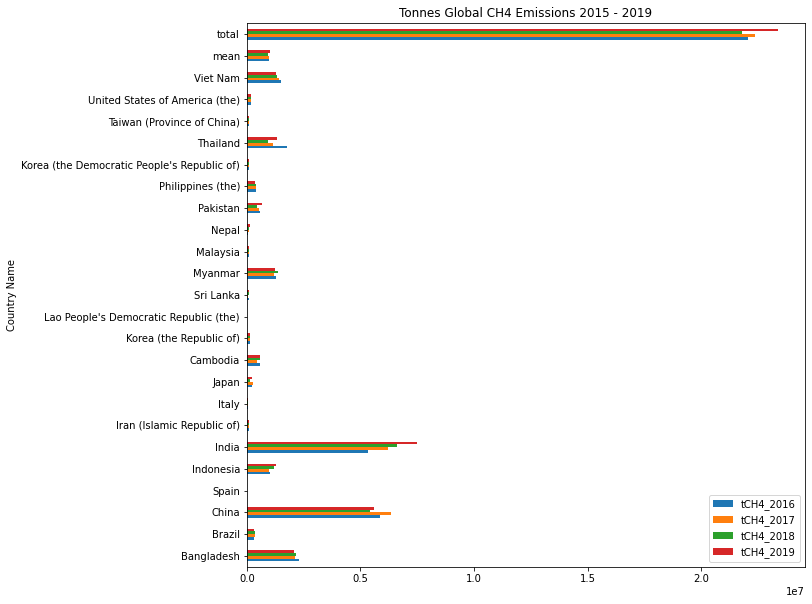

In [203]:
merge_geo_df.plot(kind = "barh", x = 'country_name_FAOSTAT', y = ['tCH4_2016', 'tCH4_2017', 'tCH4_2018', 'tCH4_2019'], xlabel = "Country Name", ylabel = "Tonnes CH4", title = "Tonnes Global CH4 Emissions 2015 - 2019", figsize = (10,10))

### CH4 Tonnage Map TRACE

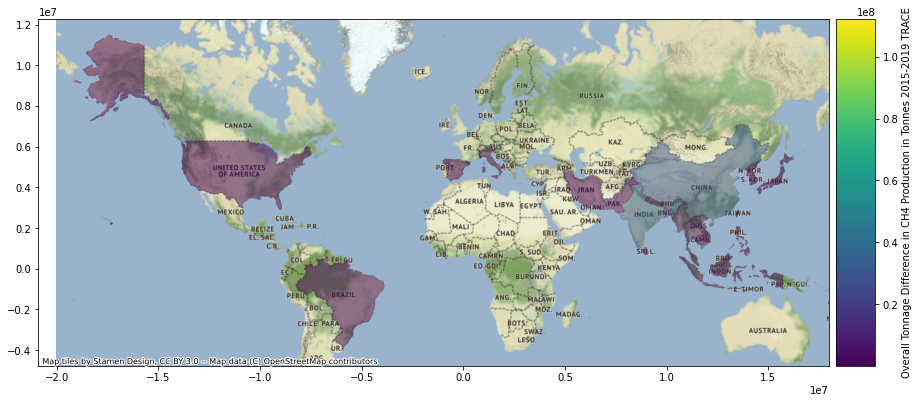

In [177]:
fig, ax = plt.subplots(1, 1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
merge_map = merge_geo_df.plot(column='Total_CH4_TRACE', ax=ax, legend=True, cax=cax, alpha = .5,legend_kwds={'label': "Overall Tonnage Difference in CH4 Production in Tonnes 2015-2019 TRACE",
                        'orientation': "vertical"})
cx.add_basemap(merge_map, zoom=3)

### Impressions

While methane is 80 times more harmful than co2 after 20 years in the atmosphere, it is not counted in 50 or 100 year climate guidelines.  If we were to consider methane emissions by converting to Co2 equivalency it may prove difficult for states to meet climate goals.  

With that said, let us review the equivalent co2 impact next.

## Co2 Equivalency

In [191]:
co2_data = merge_geo_df[['country_name_FAOSTAT', 'continent','CO2_abs_percent_diff_totals', 'CO2_relative_percent_diff_totals', 'CO2_diff_totals','tCO2_2015_FAOSTAT','tCO2_2015_TRACE', 'tCO2_2016_FAOSTAT', 'tCO2_2016_TRACE', 'tCO2_2017_FAOSTAT', 'tCO2_2017_TRACE','tCO2_2018_FAOSTAT','tCO2_2018_TRACE', 'tCO2_2019_FAOSTAT','tCO2_2019_TRACE']].copy()
co2_data

,country_name_FAOSTAT,continent,CO2_abs_percent_diff_totals,CO2_relative_percent_diff_totals,CO2_diff_totals,tCO2_2015_FAOSTAT,tCO2_2015_TRACE,tCO2_2016_FAOSTAT,tCO2_2016_TRACE,tCO2_2017_FAOSTAT,tCO2_2017_TRACE,tCO2_2018_FAOSTAT,tCO2_2018_TRACE,tCO2_2019_FAOSTAT,tCO2_2019_TRACE
0,Bangladesh,Asia,63.425917,-92.881337,-1.316277e+08,28282335.0,5.861049e+07,2.733701e+07,5.695395e+07,2.886328e+07,5.247394e+07,2.861478e+07,5.353076e+07,2.861864e+07,5.177463e+07
1,Brazil,South America,93.222402,-174.610414,-2.742306e+07,3472757.5,8.525583e+06,3.156955e+06,7.760473e+06,3.258072e+06,9.312934e+06,3.040380e+06,9.292575e+06,2.777120e+06,8.236783e+06
2,China,Asia,9.421813,-9.887609,-6.605732e+07,135164847.5,1.533412e+08,1.349980e+08,1.464883e+08,1.350032e+08,1.588768e+08,1.325543e+08,1.353491e+08,1.303614e+08,1.400838e+08
3,Spain,Europe,124.705066,76.811284,5.173455e+06,1377055.0,2.853661e+05,1.376828e+06,3.337007e+05,1.355810e+06,3.043248e+05,1.323125e+06,3.513524e+05,1.302462e+06,2.870810e+05
4,Indonesia,Asia,70.153790,51.936188,1.543040e+08,60198837.5,3.209122e+07,5.969141e+07,2.557824e+07,6.063226e+07,2.403832e+07,6.014035e+07,2.942454e+07,5.644011e+07,3.166670e+07
5,India,Asia,32.086209,-38.217479,-2.201589e+08,114506210.0,1.554972e+08,1.139784e+08,1.327353e+08,1.155198e+08,1.557113e+08,1.165289e+08,1.647450e+08,1.155354e+08,1.875389e+08
6,Iran (Islamic Republic of),Asia,13.260902,12.436318,1.631548e+06,2912167.5,2.193602e+06,3.275212e+06,2.295030e+06,2.180840e+06,2.405054e+06,2.348415e+06,2.218936e+06,2.402585e+06,2.375050e+06
7,Italy,Europe,80.187551,57.238482,8.169930e+06,2864370.0,1.248992e+06,2.950075e+06,1.234446e+06,2.950075e+06,1.360920e+06,2.736595e+06,1.117475e+06,2.772378e+06,1.141729e+06
8,Japan,Asia,36.874729,31.134372,1.263498e+07,8258827.5,5.763662e+06,8.160075e+06,5.710333e+06,8.092508e+06,6.772337e+06,8.056125e+06,3.870631e+06,8.014545e+06,5.830141e+06
9,Cambodia,Asia,14.304565,-15.406481,-8.925421e+06,10920650.0,1.238675e+07,1.147508e+07,1.432925e+07,1.184363e+07,1.129261e+07,1.198407e+07,1.398153e+07,1.170947e+07,1.486819e+07
